# A little exploratory analysis

In [91]:
import pandas as pd
pd.options.display.max_colwidth = 1000

from matplotlib import pyplot as plt
%matplotlib inline

In [92]:
dataset = pd.read_csv('./yelp.csv')

### Volumetry

In [93]:
print('Number of variables:', dataset.shape[1])
print('Number of rows:', dataset.shape[0])

Number of variables: 10
Number of rows: 10000


### Quantity and types of variables

In [96]:
dataset.dtypes

business_id    object
date           object
review_id      object
stars           int64
text           object
type           object
user_id        object
cool            int64
useful          int64
funny           int64
dtype: object

### Does the column contain null values?

In [97]:
dataset.isna().any()

business_id    False
date           False
review_id      False
stars          False
text           False
type           False
user_id        False
cool           False
useful         False
funny          False
dtype: bool

### Balance of the output variable

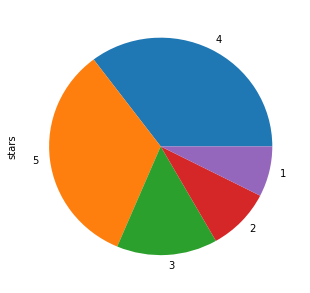

In [98]:
dataset.stars.value_counts().plot.pie(figsize=(5,5))

#### The output variable is extremely unblanced. The values '4' and '5' appear more than twice than the other values.

# Data preprocessing

### Let's take only the review text colum from the dataset

In [118]:
reviews = dataset.text

### Next, we need to tokenize the text, remove stopwords and punctuation, apply stemming and get the 'Bag of words' (unique words and its number of occurrences)

In [146]:
import string

from nltk import word_tokenize

from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer

tokens = reviews.apply(word_tokenize)

filtered_tokens = tokens.apply(
    lambda x: [token for token in x if token not in stopwords.words('english')])

even_more_filtered_tokens = filtered_tokens.apply(
    lambda x: [token for token in x if token not in string.punctuation])

stemmer = PorterStemmer()
stemmed_tokens = even_more_filtered_tokens.apply(
    lambda x: [stemmer.stem(token) for token in x])

# In stemmed_tokens, every example is a list of tokens,
# Apparently, CountVectorizer doesn't accept this structure
# So we need to go back to a string, but this time with the punctuation removed
# and the stemmed words

stemmed_strings = stemmed_tokens.apply(lambda x: ' '.join(x))

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(stemmed_strings)
print(bag_of_words.shape)

(10000, 21266)


# Machine Learning

### First, we want to prepare the INPUT and OUTPUT datasets for the models.

In [149]:
INPUT = pd.DataFrame(bag_of_words.toarray(), columns=count_vectorizer.get_feature_names())

# Use the 'stars' column from the original dataset as the OUTPUT for the model
OUTPUT = dataset.stars

### Let's test if the INPUT and OUTPUT datasets contain the same number of rows...

In [150]:
print(INPUT.shape)
print(OUTPUT.shape)

(10000, 21266)
(10000,)


### Now, we have to split those datasets into TRAIN and TEST.

In [152]:
from sklearn.cross_validation import train_test_split

TRAIN_INPUT, TEST_INPUT, TRAIN_OUTPUT, TEST_OUTPUT = train_test_split(INPUT, OUTPUT, test_size=0.3)

print(TRAIN_INPUT.shape)
print(TEST_INPUT.shape)

print(TRAIN_OUTPUT.shape)
print(TEST_OUTPUT.shape)

(7000, 21266)
(3000, 21266)
(7000,)
(3000,)


# Models:

### First, let's define a function to evaluate the models

In [162]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model):
    sets = [('TRAIN', [TRAIN_INPUT, TRAIN_OUTPUT]), ('TEST', [TEST_INPUT, TEST_OUTPUT])]
        
    for set_name, set_data in sets:
        inputs = set_data[0]
        outputs = set_data[1]
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions, average='weighted'))
        print('Recall:', recall_score(outputs, predictions, average='weighted'))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0,1,2,3,4], ['1','2','3','4','5'])
        plt.yticks([0,1,2,3,4], ['1','2','3','4','5'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

### Time to train and evaluate our first model: a logistic regression

TRAIN ################################################################################
Accuracy: 0.9658571428571429
Precision: 0.966286623057677
Recall: 0.9658571428571429



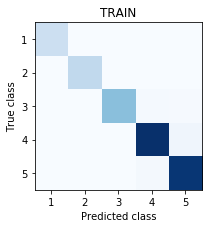

TEST ################################################################################
Accuracy: 0.489
Precision: 0.48437322354032525
Recall: 0.489



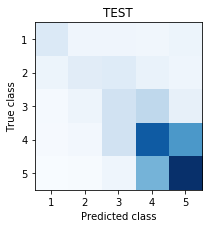

In [163]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression()

lr_classifier.fit(TRAIN_INPUT, TRAIN_OUTPUT)

evaluate_model(lr_classifier)

### Second try! Naive Bayes

TRAIN ################################################################################
Accuracy: 0.7508571428571429
Precision: 0.787673060230342
Recall: 0.7508571428571429



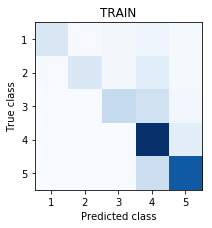

TEST ################################################################################
Accuracy: 0.498
Precision: 0.4846407515983856
Recall: 0.498



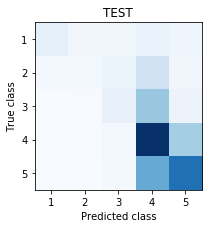

In [164]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB().fit(TRAIN_INPUT, TRAIN_OUTPUT)
evaluate_model(nb_classifier)

# Conclusions:

The models are not getting good results with the test dataset.

As we can see in the confussion matrix, the models are having problems to differentiate '4 stars' from '5 stars'.

The first reason why we can not achieve good predictions is the great imbalance of the output variable (many more examples of 4 and 5 stars than all others).

Another reason why the models are confusing 4 and 5 stars may be the similarity between the words used in the reviews.